In [29]:
import torch
import numpy as np

from torchvision.datasets import MNIST
import torchvision.transforms.v2 as T
import matplotlib.pyplot as plt

In [ ]:
mnist_train = MNIST('../datasets/mnist', transform=T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True)]), download=True)

In [ ]:
mnist_train.data = mnist_train.data.unsqueeze(1)

In [ ]:
mnist_train.data.shape

torch.Size([60000, 1, 28, 28])

In [ ]:
answers = mnist_train.targets

In [ ]:
answers.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
mean = mnist_train.data.to(torch.float32).mean().item() / 255
std = mnist_train.data.to(torch.float32).std().item() / 255
normalize = T.Normalize(mean=(mean,), std=(std,))
normalize_mnist_train = normalize(mnist_train.data.to(torch.float32) / 255)

In [ ]:
mean = mnist_train.data.to(torch.float32).mean().item() / 255
mean

0.13066047219669116

In [ ]:
std = mnist_train.data.to(torch.float32).std().item() / 255
std

0.30810780244715075

In [ ]:
normalize = T.Normalize(mean=(mean,), std=(std,))

In [ ]:
normalize_mnist_train = normalize(mnist_train.data.to(torch.float32) / 255)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(normalize_mnist_train, answers, test_size=0.2, shuffle=True)

In [ ]:
from torch.utils.data import TensorDataset
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_val_tensor, y_val_tensor)

<ipython-input-15-653e0577d639>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
<ipython-input-15-653e0577d639>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)
<ipython-input-15-653e0577d639>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
<ipython-input-15-653e0577d639>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().d

In [ ]:
train_dataset.tensors[0].shape

torch.Size([48000, 1, 28, 28])

In [ ]:
from torch.utils.data import DataLoader


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [14]:
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Optimizer
from tqdm import tqdm


def train(model: nn.Module, data_loader: DataLoader, optimizer: Optimizer, loss_fn, device: torch.device):
    model.train()
    total_loss, total_correct = 0, 0

    for x, y in tqdm(data_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        loss.backward()
        total_loss += loss.item()
        total_correct += (output.argmax(dim=1) == y).sum().item()
        optimizer.step()

    return total_loss / len(data_loader), total_correct / len(data_loader.dataset)

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


@torch.inference_mode()
def evaluate(model: nn.Module, data_loader: DataLoader, loss_fn, device: torch.device):
    model.eval()
    total_loss, total_correct = 0, 0
    for x, y in tqdm(data_loader):
        print(x.shape, y.shape)
        x, y = x.to(device), y.to(device)
        y = y.squeeze()
        output = model(x)
        loss = loss_fn(output, y)
        total_loss += loss.item()
        total_correct += (output.argmax(dim=1) == y).sum().item()

    return total_loss / len(data_loader), total_correct / len(data_loader.dataset)

In [16]:
from IPython.display import clear_output


def fit(model, train_loader, valid_loader, optimizer, loss_fn, device, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []
    best_accuracy = float('inf')
    best_model_path = "checkpoints/best_model.pt"
    best_optimizer_path = "checkpoints/best_optimizer.pt"

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_loader, optimizer, loss_fn, device)
        valid_loss, valid_accuracy = evaluate(model, valid_loader, loss_fn, device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()
        print(train_accuracy_history)
        if train_accuracy < best_accuracy:
            best_accuracy = train_accuracy
            torch.save(model.state_dict(), best_model_path)
            torch.save(optimizer.state_dict(), best_optimizer_path)

In [17]:
from torchvision.models import resnet18
from torchvision.models import ResNet18_Weights

In [18]:
! pip install Adam
from torch.optim import Adam

In [20]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [21]:
import torch
import torch.nn as nn
from torchvision.models import resnet18

class CustomResNet(nn.Module):
    def __init__(self, ):
        super(CustomResNet, self).__init__()
        self.pre_conv = nn.Conv2d(
            in_channels=1,
            out_channels=3,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False
        )
        self.resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.resnet = self.resnet.to(device)
        self.resnet.requires_grad_(False)
        self.resnet.layer4.requires_grad_(True)
        self.resnet.fc.requires_grad_(True)

    def forward(self, x):
        x = self.pre_conv(x)
        x = self.resnet(x)
        return x

model = CustomResNet()

In [ ]:
model

CustomResNet(
  (pre_conv): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [ ]:
model = model.to(device)

optimizer = Adam(
    [
        {'params': model.resnet.fc.parameters(), 'lr': 1e-3},
        {'params': model.resnet.layer4.parameters(), 'lr': 1e-4}
    ]
)
loss_fn = nn.CrossEntropyLoss()
fit(
    model,
    train_loader, valid_loader,
    optimizer, loss_fn, device, 10, 'ResNet18 pretrained'
)

[0.9811458333333334, 0.9849166666666667, 0.9886875, 0.988875, 0.9907083333333333, 0.99175, 0.9924583333333333, 0.9936875, 0.9929166666666667, 0.9937708333333334] [0.96675, 0.9668333333333333, 0.9671666666666666, 0.9670833333333333, 0.9705, 0.97075, 0.9718333333333333, 0.974, 0.9705, 0.9728333333333333]


In [30]:
model = CustomResNet()
model.load_state_dict(torch.load("checkpoints/best_model.pt"))

<ipython-input-30-f4bf898a8a5e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoints/best_model.pt"))


<All keys matched successfully>

In [2]:
import torch
import numpy as np

import torchvision.transforms.v2 as T
import matplotlib.pyplot as plt

In [3]:
torch.cuda.is_available()

True

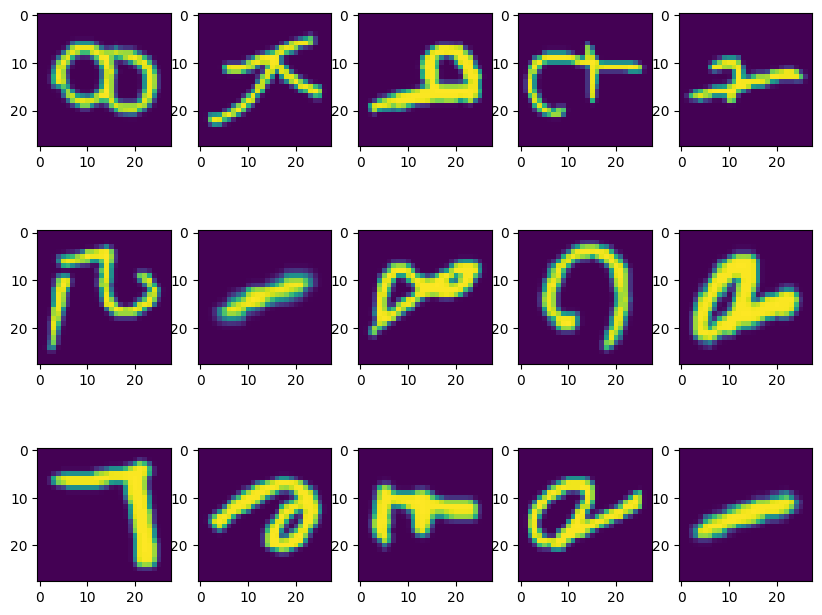

In [4]:
TRAIN_DATA_FILE = 'emnist-byclass-train.npz'
TEST_DATA_FILE = 'emnist-byclass-test.npz'
data = np.load(TRAIN_DATA_FILE)
train_labels = data['training_labels']
train_images = data['training_images']
import matplotlib.pyplot as plt
fig,axes = plt.subplots(3,5,figsize=(10,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(train_images[i].reshape([28,28]))

In [5]:
train_labels

array([ 8, 20, 39, ...,  8,  9,  8], dtype=uint8)

In [6]:
train_images = torch.tensor(train_images)
train_images.data = train_images.data.unsqueeze(1)
train_images.data.shape

torch.Size([697932, 1, 28, 28])

In [36]:
data.files


['testing_images']

In [37]:
TEST_DATA_FILE = 'emnist-byclass-test.npz'
data = np.load(TEST_DATA_FILE)
test_images = data['testing_images']

In [43]:
test = torch.tensor(test_images)

In [48]:
test = test.data.unsqueeze(1)

In [49]:
test.shape

torch.Size([116323, 1, 28, 28])

In [50]:
normalize_test_images = normalize(torch.tensor(test_images).data.to(torch.float32) / 255)

In [7]:
mean = train_images.data.to(torch.float32).mean().item() / 255
std = train_images.data.to(torch.float32).std().item() / 255
normalize = T.Normalize(mean=(mean,), std=(std,))
normalize_train_images = normalize(train_images.data.to(torch.float32) / 255)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(normalize_train_images, train_labels, test_size=0.001, shuffle=True)

In [9]:
from torch.utils.data import TensorDataset
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_val_tensor, y_val_tensor)

<ipython-input-9-653e0577d639>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
<ipython-input-9-653e0577d639>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(X_val, dtype=torch.float32)


In [11]:
from torch.utils.data import DataLoader


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)

In [22]:
model = CustomResNet()
model.load_state_dict(torch.load("checkpoints/best_model.pt"))

<ipython-input-22-f4bf898a8a5e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoints/best_model.pt"))


<All keys matched successfully>

In [23]:
device = torch.device("cuda:0")
model = model.to(device)
device = next(model.parameters()).device
print("Model is on:", device)

Model is on: cuda:0


In [31]:
model = model.to(device)

optimizer = Adam(
    [
        {'params': model.resnet.fc.parameters(), 'lr': 1e-3},
        {'params': model.resnet.layer4.parameters(), 'lr': 1e-4}
    ]
)
loss_fn = nn.CrossEntropyLoss()
fit(
    model,
    train_loader, valid_loader,
    optimizer, loss_fn, device, 10, 'ResNet18 pretrained'
)

[0.843860167461713, 0.8503945590719901, 0.8549052398477412, 0.8591792712346213, 0.8622915692579536, 0.8650252282590923, 0.8682508311413385, 0.8700637088839615, 0.8719913257242189, 0.8738271512863687]


In [55]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

test_loader = DataLoader(normalize_test_images)
ids = []
predictions = []
model.eval()


with torch.no_grad():
    for index, x in tqdm(enumerate(test_loader), total=len(test_loader)):
        x = x.to(device)
        x = x.unsqueeze(0)
        output = model(x)
        batch_size = x.size(0)
        current_ids = list(range(index * test_loader.batch_size, index * test_loader.batch_size + batch_size))
        predictions.extend(output.argmax(dim=1).cpu().numpy())
        ids.extend(current_ids)
results_df = pd.DataFrame({
    'Id': ids,
    'Category': predictions
})
results_df.to_csv('predictions.csv', index=False)

print("Results saved to predictions.csv")


100%|██████████| 116323/116323 [06:13<00:00, 311.11it/s]


Results saved to predictions.csv
